# <center>个性化联邦学习算法演示</center>

## 如何通过ModelArts MoXing API实现个性化联邦学习

## 环境准备

In [ ]:
from IPython.display import clear_output
import os
import shutil
!wget https://obsfs-notebook.obs.cn-north-4.myhuaweicloud.com/FedAMP.zip
if os.path.exists('FedAMP'):
    shutil.rmtree('FedAMP')
!mkdir FedAMP 
!unzip FedAMP.zip -d FedAMP
!rm FedAMP.zip
clear_output(wait=False)    
!pip install torchvision==0.5.0
clear_output(wait=False)
!pip install torch==1.4.0
clear_output(wait=False)
!pip install FedAMP/package/moxing_pytorch-1.17.3.fed-cp36-cp36m-linux_x86_64.whl
!rm -r FedAMP/package
clear_output(wait=False)

## 概述

自分组个性化联邦学习FedAMP是华为云自研联邦学习框架。该框架利用注意消息传递机制（如图一）让拥有相似数据分布的客户进行更多合作，并对每个客户的模型进行个性化定制，从而有效处理普遍存在的数据分布不一致问题，并大幅度提高联邦学习性能。<br>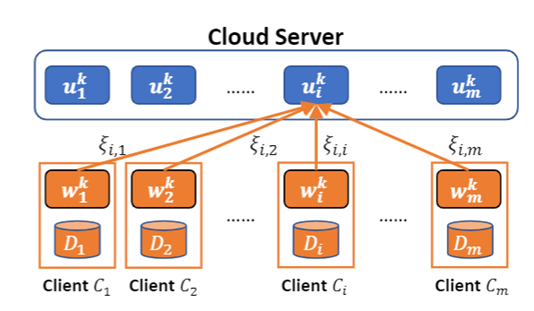

                         图一：FedAMP注意消息传递机制

相关论文现已被AAAI2021接收，并已集成至ModelArts MoXing。下面我们通过一个实际样例，带领大家体验如何使用FedAMP在ModelArts MoXing中的API来实现在非均匀分布数据下的联邦学习。本例子将实现一个62个租户的联邦学习，其任务是通过个性化联邦学习，每个租户都获得适合自己数据分布的分类模型。

1. 加载所需要的数据集，这里使用了EMNIST数据集。我们将EMNIST数据集分成如下三组：

   * 第一组有10个租户，这些租户每个有1000条训练数据和100条验证数据，其中80%的数据为数字，剩下的20%为大写及小写字母。
   * 第二组有26个租户，这些租户每个有700条训练数据和100条验证数据，其中80%的数据为大写字母，剩下的20%为数字及小写字母。
   * 第三组有26个租户，这些租户每个有400条训练数据和100条验证数据，其中80%的数据为大写字母，剩下的20%为数字及大写字母。
   

2. 定义一个网络，这里我们使用的是联邦学习中常用的两层卷积和两层全连接的网络。

3. 设置联邦学习环境。

4. 进行个性化联邦学习。

5. 结果展示。

论文链接： https://arxiv.org/pdf/2007.03797.pdf

> 本演示适用于CPU和GPU环境。

In [2]:
import torch
import numpy as np
import random
import moxing as mox
from moxing.framework.federated import fed_algorithm
from moxing.framework.federated import fed_backend
from moxing.framework.federated import fed_server
from moxing.pytorch.executor.federated.util import torch_load
from moxing.pytorch.executor.federated.util import torch_save
from moxing.pytorch.executor.federated.util import TorchFedHook
from moxing.pytorch.executor.federated import client
import matplotlib.pyplot as plt
%matplotlib inline
from moxing.framework.federated.fed_algorithm import FedAMP
import torch.nn.functional as F

if mox.file.is_directory('/tmp/fed_workspace/'):
    mox.file.remove('/tmp/fed_workspace/', recursive=True)


INFO:root:Using MoXing-v1.17.3-
INFO:root:Using OBS-Python-SDK-3.20.7
INFO:matplotlib.font_manager:font search path ['/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/afm', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
INFO:matplotlib.font_manager:generated new fontManager


## 建立数据读取类和数据结构类

In [3]:
class DataFileLoaderHorizontal():
    def __init__(self, data=None, label=None):
        if data is None:
            self.data = data
        if label is None:
            self.label = label
            
    def getDataToTorch(self):
        return torch.FloatTensor(self.data), torch.FloatTensor(self.label)


    def load_file_binary(self, data_filename=None, label_filename=None):
        assert data_filename is not None
        assert label_filename is not None
        self.data = np.load(data_filename, allow_pickle=True)
        self.label = np.load(label_filename, allow_pickle=True)
        self.data, self.label = self.data.astype(float), self.label.astype(float)


class m_Data():
    def __init__(self):
        self.train_samples          = None
        self.train_labels           = None
        self.test_samples           = None
        self.train_samples          = None

## 将数据读入对应虚拟租户

In [4]:
num_clients = 62
dfl = DataFileLoaderHorizontal()
train_sample_filename = 'FedAMP/EMNIST/client_train_samples_'
train_label_filename = 'FedAMP/EMNIST/client_train_labels_'
val_sample_filename = 'FedAMP/EMNIST/client_test_samples_'
val_label_filename = 'FedAMP/EMNIST/client_test_labels_'
filename_sx = '.npy'
input_dim = (-1, 1, 28, 28)
CUDA_DEVICE = 0
GPU = torch.cuda.is_available()
client_data = []

for i in range(num_clients):
    m_data = m_Data()
    # Load training data
    dfl.load_file_binary(data_filename=train_sample_filename + str(i) + filename_sx,
                         label_filename=train_label_filename + str(i) + filename_sx)
    samples, labels = dfl.getDataToTorch()
    if GPU:
        m_data.train_samples = samples.reshape(input_dim).cuda(CUDA_DEVICE)
        m_data.train_labels = labels.squeeze().cuda(CUDA_DEVICE)   
    else:
        m_data.train_samples = samples.reshape(input_dim)
        m_data.train_labels = labels.squeeze()
        
    # Load validation data
    dfl.load_file_binary(data_filename=val_sample_filename + str(i) + filename_sx,
                         label_filename=val_label_filename + str(i) + filename_sx)
    samples, labels = dfl.getDataToTorch()
    if GPU:
        m_data.val_samples = samples.reshape(input_dim).cuda(CUDA_DEVICE)
        m_data.val_labels = labels.squeeze().cuda(CUDA_DEVICE)
    else:
        m_data.val_samples = samples.reshape(input_dim)
        m_data.val_labels = labels.squeeze()
        
    client_data.append(m_data)

## 建立两层卷积和两层全连接的网络

In [5]:
class CNN(torch.nn.Module):
    def __init__(self, n_channel0=1, n_channel1=32, n_channel2=64,
                 kernel_size=5, stride=1, padding=2,
                 n_fc_input=3136, n_fc1=512, n_output=62):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=n_channel0, out_channels=n_channel1,
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = torch.nn.Conv2d(in_channels=n_channel1, out_channels=n_channel2,
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.fc1 = torch.nn.Linear(n_fc_input, n_fc1)
        self.fc2 = torch.nn.Linear(n_fc1, n_output)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
print(CNN())

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=62, bias=True)
)


## 设置联邦学习虚拟租户及FedAMP参数
   1. alpha--定义为FedAMP算法中本地模型的权重参数
   2. mul--注意力参数，数值越大注意力增大，为零时将类似于经典联邦学习算法FedAvg
   3. display--是否展示模型相似性及注意力权重

In [6]:
os.environ['MOX_FEDERATED_SIZE'] = str(num_clients)
os.environ['MOX_FEDERATED_BACKEND'] = 'obs'
os.environ['MOX_FEDERATED_URL'] = '/tmp/fed_workspace/'


stepsize = 0.001 #local training stepsize

alg_config = fed_algorithm.FedAMPConfig(alpha=0.1, mul=50.0, display=True) #FedAMP parameter setting
client_models = []
client_feds = []
optimizer_list = []
if GPU:
    base_model = CNN().cuda(CUDA_DEVICE)
else:
    base_model = CNN()

for i in range(num_clients):
    os.environ['MOX_FEDERATED_RANK'] = str(i)

    backend_config = fed_backend.FederatedBackendOBSConfig(
        load_fn=torch_load,
        save_fn=torch_save,
        suffix='pth')

    # create client
    fed_alg = fed_algorithm.build_algorithm(alg_config)
    backend = fed_backend.build_backend(
        config=backend_config,
        fed_alg=fed_alg)
    fed_client = client.FederatedHorizontalPTClient(backend=backend)
    fed_client.connect()

    client_feds.append(fed_client)
    if GPU:
        model = CNN().cuda(CUDA_DEVICE)
    else:
        model = CNN()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=stepsize)
    model.load_state_dict(base_model.state_dict())
    client_models.append((model, optimizer))
    optimizer_list.append(optimizer)

## 建立模型融合虚拟服务

In [7]:
# create server
fed_alg = fed_algorithm.build_algorithm(alg_config)
fed_be_config = fed_backend.FederatedBackendOBSConfig(
  load_fn=torch_load, save_fn=torch_save, suffix='pth', hooks=[TorchFedHook()])
fed_be = fed_backend.build_backend(fed_be_config, fed_alg)
server = fed_server.FederatedServerHorizontal(fed_be)
server.backend.wait_ready()

INFO:root:waiting for all clients ready...


## 模型训练和评估模块

In [8]:
def evaluation(model, test_samples, test_labels):
    with torch.no_grad():
        outputs = model(test_samples)
        _, preds = outputs.max(1)
        test_acc = preds.eq(test_labels).sum() / float(len(test_labels))
    return test_acc

def train_local_clients(model, optimizer, data, num_epochs):
    train_samples =  data.train_samples
    train_labels = data.train_labels
    val_samples = data.val_samples
    val_labels = data.val_labels 
    total_num_samples = len(train_samples)
    criterion = torch.nn.CrossEntropyLoss()
    for x in range(num_epochs):
        seq = np.arange(total_num_samples)
        random.shuffle(seq)
        for begin_batch_index in range(0, total_num_samples, batch_size):
            batch_ids = seq[begin_batch_index: min(begin_batch_index + batch_size, total_num_samples)]
            inputs = train_samples[batch_ids]
            labels = train_labels[batch_ids]
            optimizer.zero_grad()
            outputs = model(inputs)    
            loss = criterion(outputs, labels.type(torch.long))
            loss.backward()
            optimizer.step()       
    test_acc = evaluation(model, val_samples, val_labels)
    return test_acc

## 个性化联邦学习
   构建完数据和租户后，就可以通过联邦学习来训练模型了。 这个过程中我们需要设置如下的参数：
   1. communication定义了总模型同步次数
   2. epochs定义了每次每个租户本地训练遍历数据次数
   3. batch_size本地训练时每个batch的大小
   我们会输出每次本地训练和模型合成后模型在验证数据集上的平均准确性。并输出了每个租户的模型之间的相似性，以及合成个性化模型时权重。

INFO:root:waiting for next federation...
INFO:root:ready to do federation. <step={'19'}> <clients=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]> <algorithms=FedAMP(alpha=0.1, mul=50.0, sim=None)>



===Local training is completed===
Communication round: 20
===Starting model aggregation===


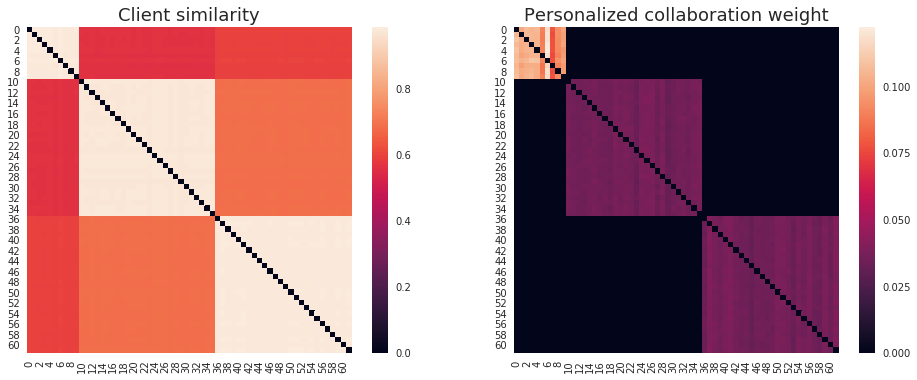

===Model aggregation is completed===
Local model average validation test accuracy: 75.55%
Personalized cloud model average validation accuracy: 81.19%
====Training Completed====


In [9]:
batch_size = 100
num_epochs = 5
communication = 20
val_acc_cloud = []
val_acc_client = []

for rounds in range(communication):
    val_acc_total = 0
    # Train model locally
    
    print("===Starting local training===")
    
    for i in range(num_clients):
        print("Training client " + str(i), end='\r')
        model, optimizer = client_models[i]
        local_client = client_feds[i]
        data = client_data[i]
        acc = train_local_clients(model, optimizer, data, num_epochs)   
        val_acc_total += acc
        local_client.send_model(parameters=optimizer.param_groups[0]['params'])   
    
    # server aggregate  
    val_acc_avg = val_acc_total / num_clients *100
    val_acc_client.append(val_acc_avg)
    
    clear_output(wait=True)
    print("\n===Local training is completed===")
    print("Communication round: {0:1d}".format(rounds+1))
    print("===Starting model aggregation===")
    
    step = list(server.backend.wait_next())[-1]
    ctx = server.backend.get_context()
    server.backend.aggregate_data(step, ctx.names)
    
    print("===Model aggregation is completed===")
    
    print("Local model average validation test accuracy: {0:5.2f}%".format(val_acc_avg))
    
    # Update local model
    val_acc_total = 0
    with torch.no_grad():
        for i in range(num_clients):
            val_samples =   client_data[i].val_samples
            val_labels = client_data[i].val_labels
            local_client = client_feds[i]
            model, optimizer = client_models[i]
            new_parameters = local_client.get_model()
            local_client.clean_previous()
            local_client.next_step()
            parameters = optimizer.param_groups[0]['params']
            for p, new_p in zip(parameters, new_parameters):
                p.copy_(new_p)
            acc = evaluation(model, val_samples, val_labels)
            val_acc_total += acc
    val_acc_avg = val_acc_total / num_clients *100
    val_acc_cloud.append(val_acc_avg)
    print("Personalized cloud model average validation accuracy: {0:5.2f}%".format(val_acc_avg))      
        
print("====Training Completed====")

## 结果展示

从上面的结果可以看出，FedAMP鼓励拥有相似数据的租户进行更多的模型融合，所得到的模型注意力关系跟我们实验设计的数据分布一致。最后我们看下联邦学习工程中，云上个性化模型以及端侧模型在整个联邦学习过程中准确率变化的情况。

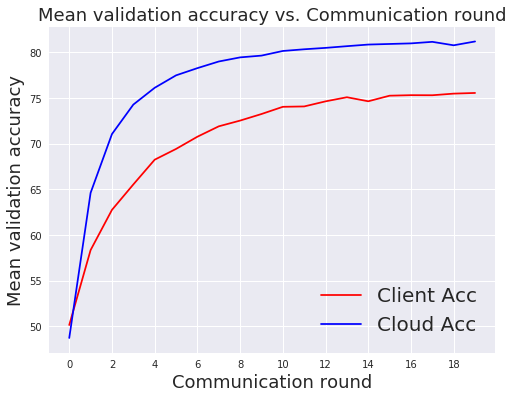

In [10]:
plt.figure(figsize=(8, 6))
x = list(range(communication))
plt.xticks(x[0:-1:2])
acc_client, = plt.plot(x, val_acc_client, color="red")
acc_cloud, = plt.plot(x, val_acc_cloud, color="blue")
plt.legend([acc_client, acc_cloud], ['Client Acc', 'Cloud Acc'], fontsize=20)
plt.xlabel("Communication round", fontsize=18)
plt.ylabel("Mean validation accuracy", fontsize=18)
plt.title("Mean validation accuracy vs. Communication round", fontsize=18)
plt.show()